In [1]:
import numpy as np

In [2]:
collision = np.load('.data/Time_series_colisao.npz')
display(collision.keys())
spreading = np.load('.data/Time_series_espalhamento.npz')
display(spreading.keys())

KeysView(NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B)

KeysView(NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...)

# Colisão | Collision

In [3]:
collision_timesteps_raw = collision['TS']
display(collision_timesteps_raw.shape)

(72, 1000, 5)

## Separando por componentes

In [4]:
components_collision: list[dict] = list()
for cmpnt in range(5):
    components_collision.append({
        "original": collision_timesteps_raw[:, :, cmpnt].T
    })

## Abordagem 1: _Autoencoder_

Escolhendo forma de definir escala dos dados.

`MaxAbsScaler`: mantém distribuição dos dados, mas altera a escala de forma que o maior valor tenha módulo igual a 1.

In [5]:
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer


chosen_scaler: Literal[
    'StandardScaler',
    'MinMaxScaler',
    'RobustScaler',
    'MaxAbsScaler',
    'QuantileTransformer',
    'PowerTransformer',
    'Normalizer'
] = 'MaxAbsScaler'
for component_dict in components_collision:
    scaler = eval(chosen_scaler)()
    scaled_data = scaler.fit_transform(component_dict["original"])
    component_dict["autoencoder"] = {
        "scaler": scaler,
        "scaled": scaled_data
    }

Definindo arquitetura da Rede Autoencoder

In [6]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from uuid import uuid4

def generate_autoencoder_collision():
    input = Input(shape=(72,))
    hidden_1 = Dense(27, activation='linear')(input)
    encoding_dim = Dense(9, activation='linear')(hidden_1)
    hidden_2 = Dense(27, activation='linear')(encoding_dim)
    output = Dense(72, activation='linear')(hidden_2)
    model = Model(input, output)
    optim = Adam(learning_rate=0.1)
    model.compile(
        optimizer=optim,
        loss='mean_absolute_percentage_error',
        metrics=[
            mean_squared_error,
            mean_absolute_percentage_error
        ])
    return model


def scheduler(epoch, lr):
    power = - 0.04 * epoch
    if epoch < 100:
        return 0.1 * np.e ** power
    else:
        return 0.001


def train_autoencoder(autoencoder, data):    
    lr_scheduler = LearningRateScheduler(schedule=scheduler)
    model_uuid = uuid4()
    checkpoint = ModelCheckpoint(filepath=f"/tmp/{model_uuid}/model.weights.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True)
    history = autoencoder.fit(
        data, data,
        batch_size = 15,
        epochs=150,
        verbose=True,
        shuffle=True,
        callbacks=[
            lr_scheduler,
            checkpoint
        ]
    )
    return history

2024-04-03 23:10:24.230564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 23:10:25.057583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Treinando rede autoencoder

In [7]:
permutation_idx = np.random.permutation(collision_timesteps_raw.shape[1])
for component in components_collision:
    component["autoencoder"]["model"] =\
        generate_autoencoder_collision()
    component["autoencoder"]["training_data"] =\
        component["autoencoder"]["scaled"][permutation_idx[:666]]
    component["autoencoder"]["training_history"] =\
        train_autoencoder(component["autoencoder"]["model"], component["autoencoder"]["training_data"])

Epoch 1/150


2024-04-03 23:10:25.761912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 23:10:25.762289: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 1/45 ━━━━━━━━━━━━━━━━━━━━ 42s 955ms/step - loss: 102.6916 - mean_absolute_percentage_error: 102.6916 - mean_squared_error: 0.6161
Epoch 1: loss improved from inf to 654.13666, saving model to /tmp/bfccfc88-4d2f-4e12-b0e2-124b95f9d65e/model.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1166.6198 - mean_absolute_percentage_error: 1166.9541 - mean_squared_error: 133.2659 - learning_rate: 0.1000
Epoch 2/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 109.0402 - mean_absolute_percentage_error: 109.0402 - mean_squared_error: 0.7678
Epoch 2: loss improved from 654.13666 to 34.56574, saving model to /tmp/bfccfc88-4d2f-4e12-b0e2-124b95f9d65e/model.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 56.5092 - mean_absolute_percentage_error: 56.5222 - mean_squared_error: 0.2684 - learning_rate: 0.0961
Epoch 3/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.5970 - mean_absolute_percentage_error: 14.5970 - mean_squared_error: 0.0178
Epoch 3: loss improved from 34.565

Testando rede autoencoder

In [8]:
for component in components_collision:
    component["autoencoder"]["testing_data_scaled"] =\
        component["autoencoder"]["scaled"][permutation_idx[666:]]
    component["autoencoder"]["prediction_scaled"] =\
        component["autoencoder"]["model"].predict(component["autoencoder"]["testing_data_scaled"])
    component["autoencoder"]["testing_data_unscaled"] =\
        component["autoencoder"]["scaler"].inverse_transform(component["autoencoder"]["testing_data_scaled"])
    component["autoencoder"]["prediction_unscaled"] =\
        component["autoencoder"]["scaler"].inverse_transform(component["autoencoder"]["prediction_scaled"])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Estatísticas de erro médio quadrático e erro médio percentual

Estatísticas sobre esses erros: mínimo obtido para um determinado timestep, máximo e média.

In [9]:
import pandas as pd

pd.set_option('display.float_format', '{:.4f}'.format)

columns = pd.MultiIndex.from_product([['MSE', 'MAPE'], ['min', 'max', 'mean']])
data = np.zeros((5, 6))
result_df = pd.DataFrame(
    data,
    index=pd.RangeIndex(0, 5, name="Component"),
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    component["autoencoder"]["mse_loss"] =\
        mean_squared_error(component["autoencoder"]["testing_data_unscaled"], component["autoencoder"]["prediction_unscaled"])
    component["autoencoder"]["mape_loss"] =\
        mean_absolute_percentage_error(component["autoencoder"]["testing_data_unscaled"], component["autoencoder"]["prediction_unscaled"])
    result_df.loc[cmpnt, ("MSE", "min")] = np.min(component["autoencoder"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "max")] = np.max(component["autoencoder"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "mean")] = np.mean(component["autoencoder"]["mse_loss"])
    result_df.loc[cmpnt, ("MAPE", "min")] = np.min(component["autoencoder"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "max")] = np.max(component["autoencoder"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "mean")] = np.mean(component["autoencoder"]["mape_loss"])

results = {
    "collision": {
        "autoencoder": {
            "stats": result_df
        }
    }
}

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(results["collision"]["autoencoder"]["stats"])

'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE                      MAPE                  
             min       max     mean    min       max    mean
Component                                                   
0         0.0001    0.0079   0.0031 0.6680    4.4818  2.5723
1         0.0003    0.0311   0.0053 0.7849    4.9055  2.4512
2         0.6269 8850.6719 249.6013 4.3810   30.5529  9.2894
3         1.8006  699.2049  74.8210 0.2324    2.2129  0.7306
4         1.5164  365.9503  38.6058 0.1606 6074.4019 18.6907

Analisando distribuição de erro com base em diferentes momentos da série

In [10]:
import pandas as pd

pd.set_option("display.float_format", '{:.4f}'.format)

components_idx = pd.Index(["Diâmetro", "Altura", "Energia Cinética", "Energia Superficial", "Energia Dissipativa"], name="Componente")
snapshots_idx = pd.Index(permutation_idx[666:], name="Snapshot")
columns = ["MSE", "MAPE"]
data = np.zeros((5 * 334, 2))

index = pd.MultiIndex.from_product([components_idx, snapshots_idx])
detailed_result_df = pd.DataFrame(
    data,
    index=index,
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MSE"] = np.array(component["autoencoder"]["mse_loss"])
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MAPE"] = np.array(component["autoencoder"]["mape_loss"])

results["collision"]["autoencoder"]["detailed_stats"] = detailed_result_df

display("Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep")
display(results["collision"]["autoencoder"]["detailed_stats"])

'Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep'

MSE   MAPE
Componente          Snapshot               
Diâmetro            833       0.0048 3.9672
                    42        0.0003 1.6422
                    280       0.0024 2.4624
                    808       0.0050 3.4702
                    159       0.0022 2.3767
...                              ...    ...
Energia Dissipativa 543       7.0712 0.2235
                    80       12.6462 0.5486
                    458       7.2951 0.2550
                    150      76.0644 1.2371
                    854       2.7442 0.1622

[1670 rows x 2 columns]

Analisando o comportamento do erro ao decorrer da série a partir de visualização de gráfico

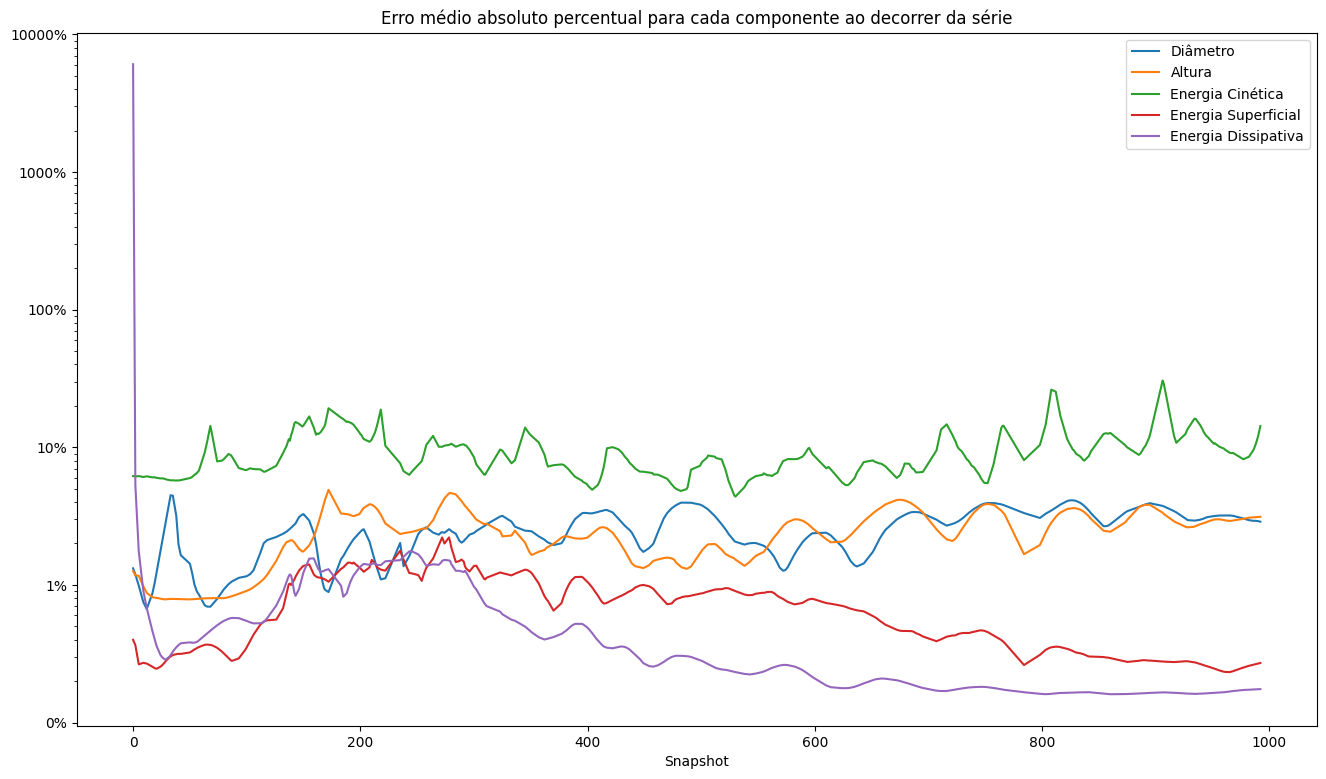

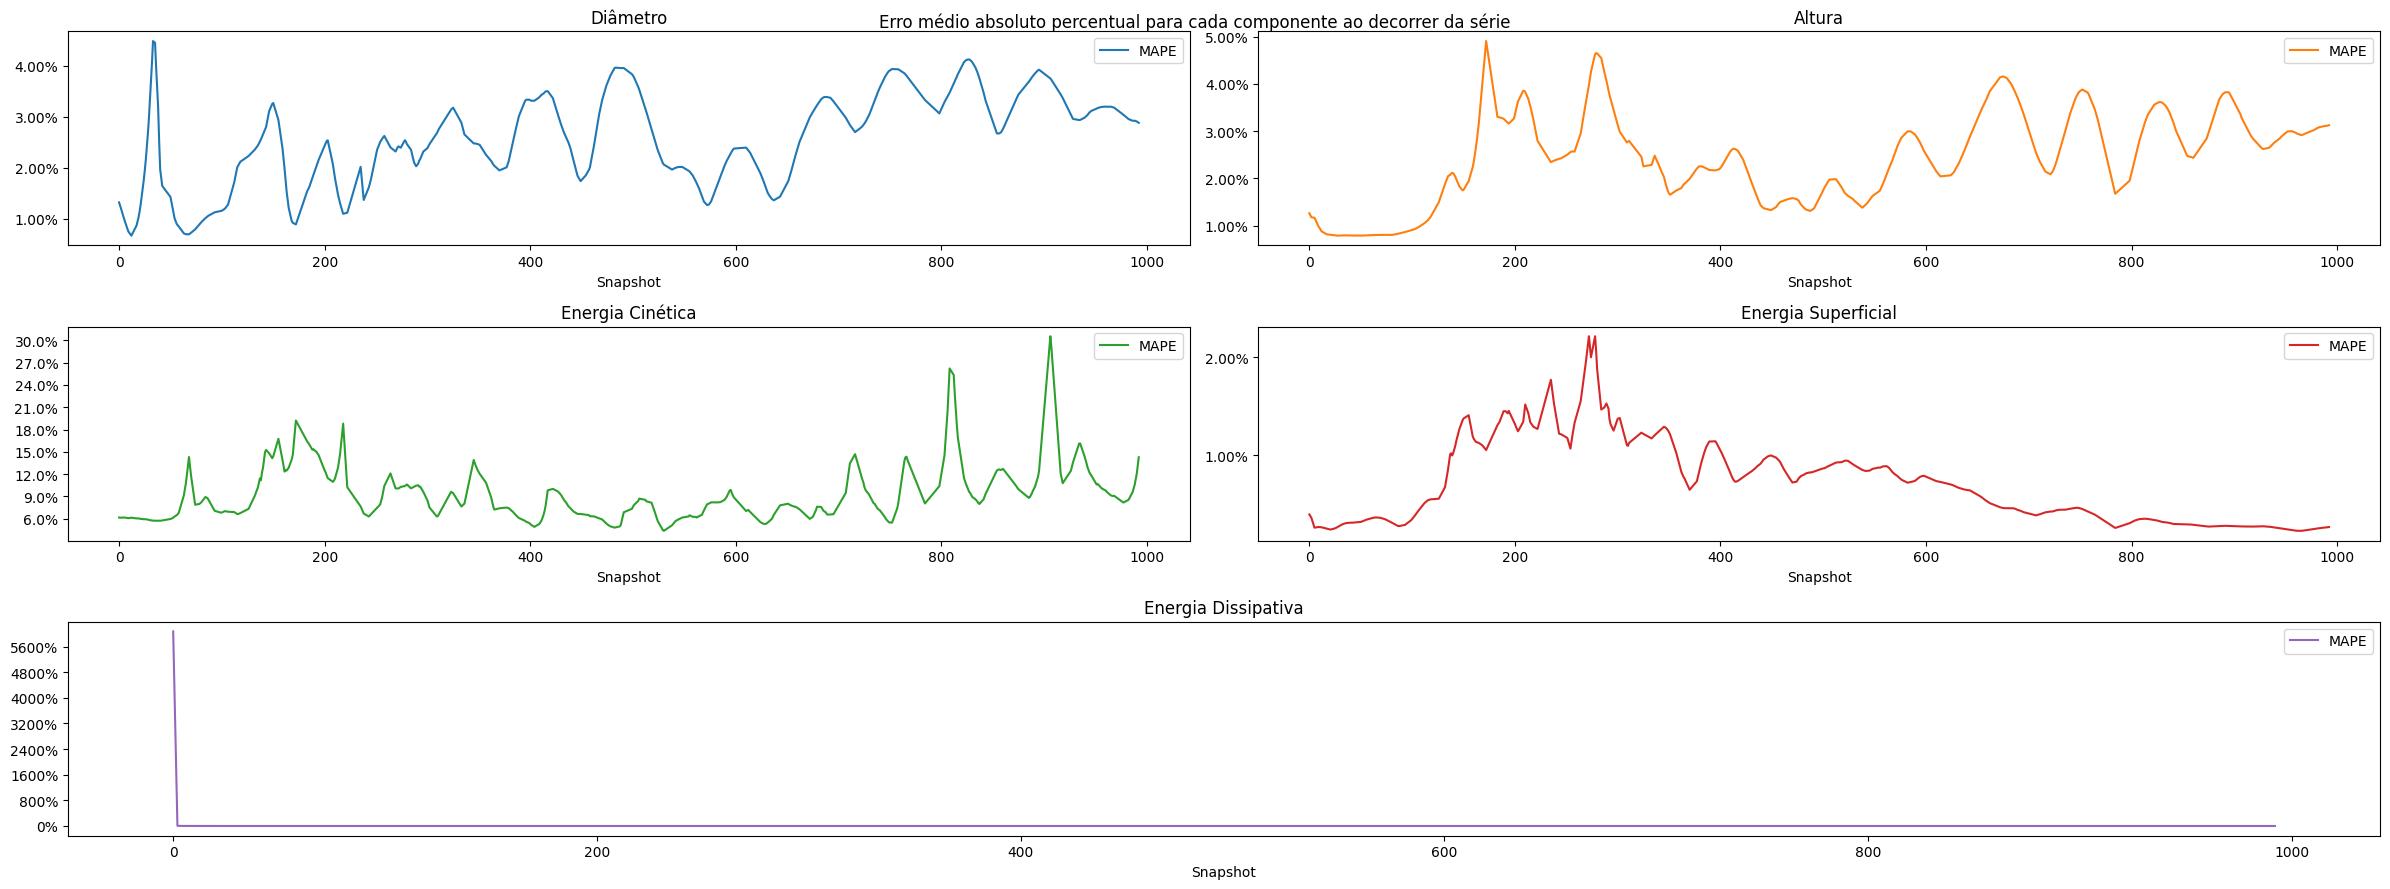

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator, PercentFormatter

fig_general, ax_general = plt.subplots(figsize=(16,9))
ax_general.set_yscale("log")
ax_general.yaxis.set_major_formatter(PercentFormatter())

fig_subs = plt.figure(figsize=(24,9))
gs = fig_subs.add_gridspec(3, 2)

for k, cmpnt in enumerate(components_idx):
    i = k // 2
    j = k % 2
    if i < 2:
        ax_sub = fig_subs.add_subplot(gs[i, j])
    else:
        ax_sub = fig_subs.add_subplot(gs[i, :])
    results["collision"]["autoencoder"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_general, label=cmpnt)
    color = ax_general.get_lines()[-1].get_color()
    results["collision"]["autoencoder"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_sub, color=color)
    ax_sub.set_title(cmpnt)
    ax_sub.legend()
    ax_sub.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_sub.yaxis.set_major_formatter(PercentFormatter())
ax_general.legend()
ax_general.set_title('Erro médio absoluto percentual para cada componente ao decorrer da série')
fig_general.savefig('.results/mape_autoencoder_collision_all.png', dpi=300)
fig_subs.tight_layout()
fig_subs.suptitle('Erro médio absoluto percentual para cada componente ao decorrer da série')
fig_subs.savefig('.results/mape_autoencoder_collision_subplots.png', dpi=300)

## Abordagem 2: PCA

Tendo em vista que o Autoencoder desempenhou melhor quando usando funções de ativação lineares, uma hipótese é que o PCA pode ser um método bastante competitivo nesse caso.

In [12]:
from sklearn.decomposition import PCA

for component in components_collision:
    # Using same encoding dim: 9
    pca = PCA(n_components=9)
    pca.fit(component["autoencoder"]["training_data"])
    reconstructed = pca.inverse_transform(pca.transform(component["autoencoder"]["testing_data_scaled"]))
    unscaled = component["autoencoder"]["scaler"].inverse_transform(reconstructed)
    component["pca"] = {
        "model": pca,
        "prediction_scaled": reconstructed,
        "prediction_unscaled": unscaled,
        "testing_data_unscaled": component["autoencoder"]["testing_data_unscaled"]
    }

In [13]:
columns = pd.MultiIndex.from_product([['MSE', 'MAPE'], ['min', 'max', 'mean']])
data = np.zeros((5, 6))
result_df = pd.DataFrame(
    data,
    index=pd.RangeIndex(0, 5, name="Component"),
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    component["pca"]["mse_loss"] =\
        mean_squared_error(component["pca"]["testing_data_unscaled"], component["pca"]["prediction_unscaled"])
    component["pca"]["mape_loss"] =\
        mean_absolute_percentage_error(component["pca"]["testing_data_unscaled"], component["pca"]["prediction_unscaled"])
    result_df.loc[cmpnt, ("MSE", "min")] = np.min(component["pca"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "max")] = np.max(component["pca"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "mean")] = np.mean(component["pca"]["mse_loss"])
    result_df.loc[cmpnt, ("MAPE", "min")] = np.min(component["pca"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "max")] = np.max(component["pca"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "mean")] = np.mean(component["pca"]["mape_loss"])

results = {
    "collision": {
        "pca": {
            "stats": result_df
        }
    }
}

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(results["collision"]["pca"]["stats"])

'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE                    MAPE                  
             min      max    mean    min       max    mean
Component                                                 
0         0.0002   0.0054  0.0025 0.6979    4.2619  2.7183
1         0.0000   0.0087  0.0027 0.1222    4.5523  2.3984
2         0.7261  75.8894 12.9576 0.2204   60.1699 14.7191
3         0.6487 260.1335 25.0394 0.0763    1.7429  0.4917
4         0.1254  59.4260  5.3791 0.0377 5629.1460 17.0531

In [14]:
components_idx = pd.Index(["Diâmetro", "Altura", "Energia Cinética", "Energia Superficial", "Energia Dissipativa"], name="Componente")
snapshots_idx = pd.Index(permutation_idx[666:], name="Snapshot")
columns = ["MSE", "MAPE"]
data = np.zeros((5 * 334, 2))

index = pd.MultiIndex.from_product([components_idx, snapshots_idx])
detailed_result_df = pd.DataFrame(
    data,
    index=index,
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MSE"] = np.array(component["pca"]["mse_loss"])
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MAPE"] = np.array(component["pca"]["mape_loss"])

results["collision"]["pca"]["detailed_stats"] = detailed_result_df

display("Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep")
display(results["collision"]["pca"]["detailed_stats"])

'Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep'

MSE   MAPE
Componente          Snapshot              
Diâmetro            833      0.0051 4.2282
                    42       0.0009 3.2079
                    280      0.0022 2.5356
                    808      0.0042 3.4078
                    159      0.0014 2.1983
...                             ...    ...
Energia Dissipativa 543      1.1548 0.1373
                    80       2.0658 0.2128
                    458      2.7237 0.1776
                    150      2.6164 0.2172
                    854      0.5113 0.0480

[1670 rows x 2 columns]

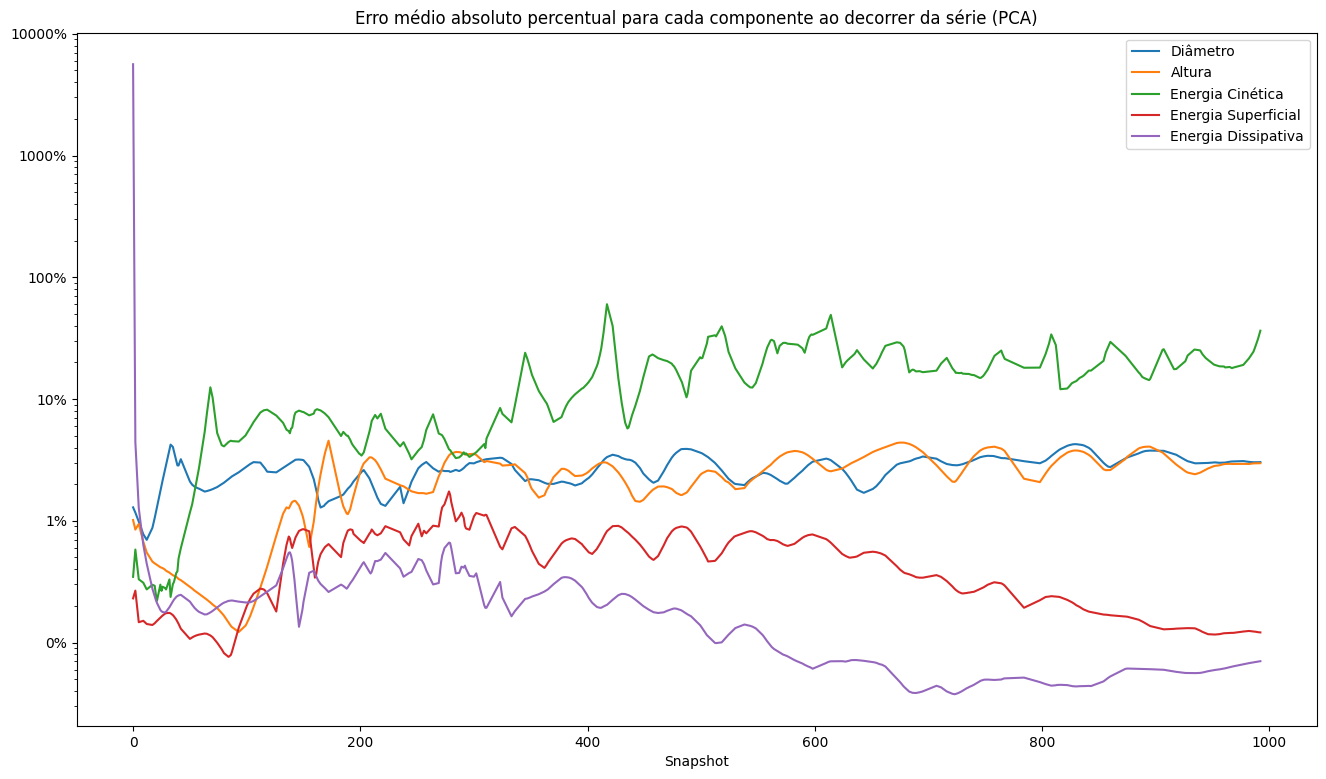

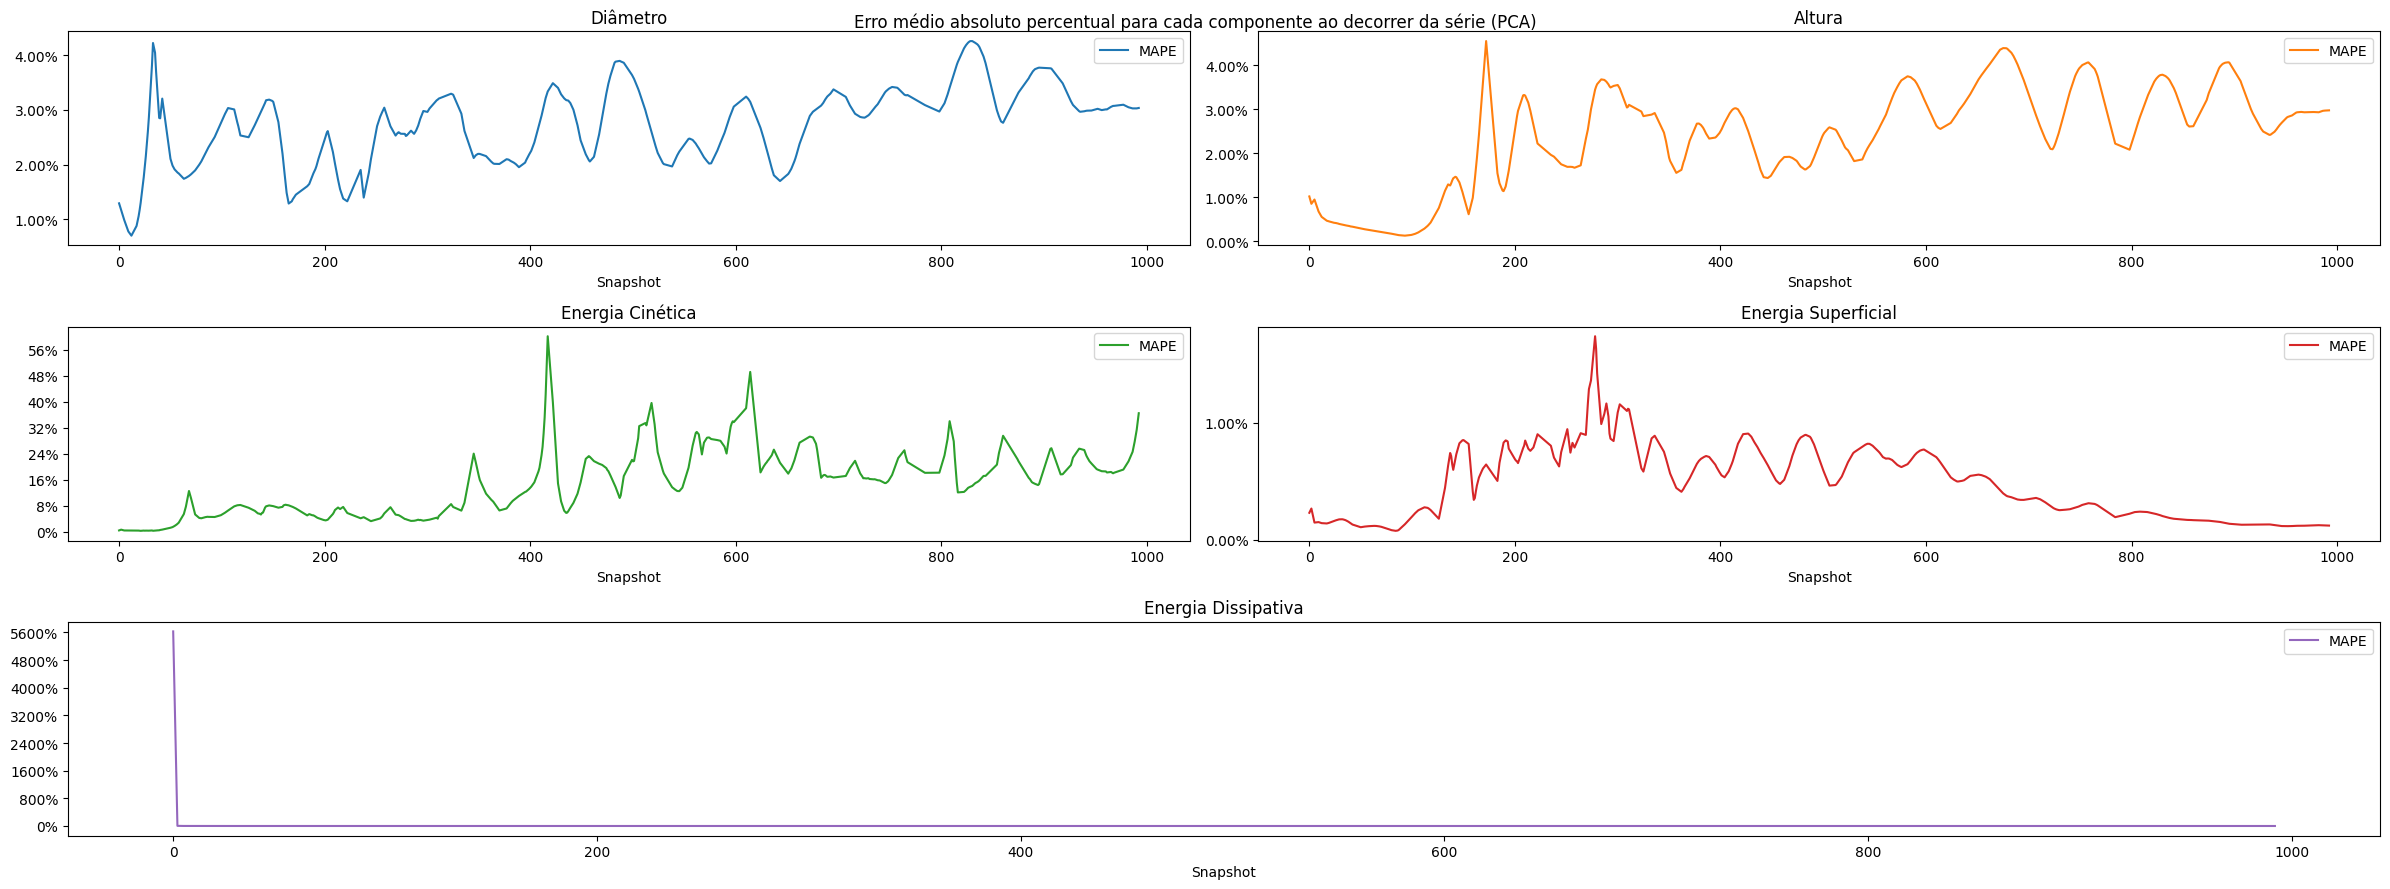

In [15]:
fig_general, ax_general = plt.subplots(figsize=(16,9))
ax_general.set_yscale("log")
ax_general.yaxis.set_major_formatter(PercentFormatter())

fig_subs = plt.figure(figsize=(24,9))
gs = fig_subs.add_gridspec(3, 2)

for k, cmpnt in enumerate(components_idx):
    i = k // 2
    j = k % 2
    if i < 2:
        ax_sub = fig_subs.add_subplot(gs[i, j])
    else:
        ax_sub = fig_subs.add_subplot(gs[i, :])
    results["collision"]["pca"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_general, label=cmpnt)
    color = ax_general.get_lines()[-1].get_color()
    results["collision"]["pca"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_sub, color=color)
    ax_sub.set_title(cmpnt)
    ax_sub.legend()
    ax_sub.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_sub.yaxis.set_major_formatter(PercentFormatter())
ax_general.legend()
ax_general.set_title('Erro médio absoluto percentual para cada componente ao decorrer da série (PCA)')
fig_general.savefig('.results/mape_pca_collision_all.png', dpi=300)
fig_subs.tight_layout()
fig_subs.suptitle('Erro médio absoluto percentual para cada componente ao decorrer da série (PCA)')
fig_subs.savefig('.results/mape_pca_collision_subplots.png', dpi=300)

##### Demonstrating that this transpose makes sense

In [16]:
# Let's test if this is correct
# Suppose we have tree simulations with 2 components each
# We have 3 timesteps
# First component is linear, second is quadratic
# First simulation starts with 1
# Second simulation starts with 2
# Third simulation starts with 3
# Therefore, first simulation first component is [1, 2, 3]
# Second simulation first component is [2, 3, 4]
# Third simulation first component is [3, 4, 5]
# First simulation second component is [1, 4, 9]
# Second simulation second component is [4, 9, 16]
# Third simulation second component is [9, 16, 25]
# Therefore, first timestep is [[1, 2, 3], [1, 4, 9]]
first_simulation = np.array([[1, 1], [2, 4], [3, 9]])
second_simulation = np.array([[2, 4], [3, 9], [4, 16]])
third_simulation = np.array([[3, 9], [4, 16], [5, 25]])
timesteps = np.array([first_simulation, second_simulation, third_simulation])
shape = timesteps.shape
display(shape)
transformed_timesteps = timesteps.transpose(1, 0, 2).reshape(shape[1], shape[0] * shape[2])
display(transformed_timesteps)

(3, 3, 2)

array([[ 1,  1,  2,  4,  3,  9],
       [ 2,  4,  3,  9,  4, 16],
       [ 3,  9,  4, 16,  5, 25]])